# News Classification using Bi-LSTM

Importing functions used in code

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.layers import Embedding
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Bidirectional, Dropout, TextVectorization, Input

from sklearn.metrics import confusion_matrix


Loading training dataset

In [2]:
train_data = pd.read_csv('train.csv')
train_data.head()

,Class Index,Title,Description
0,3,Wall St. Bears Claw Back Into the Black (Reuters),"Reuters - Short-sellers, Wall Street's dwindli..."
1,3,Carlyle Looks Toward Commercial Aerospace (Reu...,Reuters - Private investment firm Carlyle Grou...
2,3,Oil and Economy Cloud Stocks' Outlook (Reuters),Reuters - Soaring crude prices plus worries\ab...
3,3,Iraq Halts Oil Exports from Main Southern Pipe...,Reuters - Authorities have halted oil export\f...
4,3,"Oil prices soar to all-time record, posing new...","AFP - Tearaway world oil prices, toppling reco..."


Checking for null or missing values. There are no missing or null values in this dataset

In [3]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120000 entries, 0 to 119999
Data columns (total 3 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   Class Index  120000 non-null  int64 
 1   Title        120000 non-null  object
 2   Description  120000 non-null  object
dtypes: int64(1), object(2)
memory usage: 2.7+ MB


Combining title and description of news to make single text sequence

In [7]:
X_train = train_data['Title'] +" "+ train_data['Description']

## bringing label to range of 0 to 3 from range of 1 to 4
y = train_data['Class Index'].apply(lambda x: x-1)

## One hot encoding labels
y_train = pd.get_dummies(y,dtype=int)

Cheking distributon of lenghth of text sequences. 

As most of the sequeces are shorter than 75 words, we will choose 75 as out vector length while doing vectorisation.  

Max_length 177
Median_length 37.0


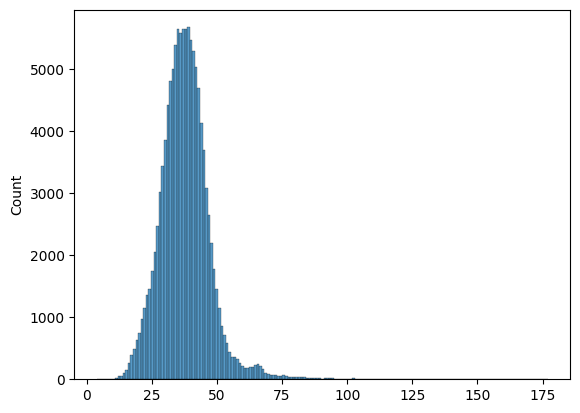

In [8]:
word_distribution = X_train.map(lambda x: len(x.split()))
max_len = word_distribution.max()
print('Max_length', max_len)
avg_len = word_distribution.median()
print('Median_length', avg_len)

## plotting histogram of number of words in sequence
sns.histplot(word_distribution, bins=175)
plt.show()

## Text Vectorisation

Total words in corpus is 81044. I am choosing vocabulary size approximately 1/3rd of total unique words for faster training

TextVectorization() module tokenises the sequence, encodes sequence into integer array and also performs padding/truncating. adapt() method is used to create a vocabulary based on given dataset. To ensure encoding new example using same vocabulary, trained vectorise layer is added as first layer in classification model  

In [ ]:
vocab_size = 25000
max_len = 75

## Vectorising input sequences. This function tokenise text, remove punctuations, convert text into integer array and pad/trncate sequence to max_len
vectorize_layer = TextVectorization(max_tokens= vocab_size, output_mode='int', output_sequence_length=max_len)
vectorize_layer.adapt(X_train)

## Model Building

1. pre-fitted vectorise layer
2. Embedding layer Embeds each word into 32 dimensional vector
3. BiLSTM layer outputs 256 hidden states(128 forward, 128 backword)
4. Dense layers - for deep learning
5. Output layer - each neuron is probability of text being of that group

In [8]:
model= Sequential([Input(shape=(1,), dtype=tf.string),
                   vectorize_layer,
                   Embedding(vocab_size,32,input_length=max_len),
                   Bidirectional(LSTM(128,activation='relu', dropout=0.25)),
                   Dense(128,activation='relu'),
                   Dropout(0.25),
                   Dense(64,activation='relu'),
                   Dropout(0.25),
                   Dense(4, activation='softmax')])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, 75)               0         
 torization)                                                     
                                                                 
 embedding_1 (Embedding)     (None, 75, 32)            800000    
                                                                 
 bidirectional_1 (Bidirectio  (None, 256)              164864    
 nal)                                                            
                                                                 
 dense_3 (Dense)             (None, 128)               32896     
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_4 (Dense)             (None, 64)               

## Model Training

In [9]:
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
classifier = model.fit(X_train,y_train,batch_size=512,epochs=5)

Epoch 1/5
235/235 [==============================] - 404s 2s/step - loss: 0.7719 - accuracy: 0.6834
Epoch 2/5
235/235 [==============================] - 433s 2s/step - loss: 5.0671 - accuracy: 0.9054
Epoch 3/5
235/235 [==============================] - 438s 2s/step - loss: 0.2449 - accuracy: 0.9238
Epoch 4/5
235/235 [==============================] - 442s 2s/step - loss: 0.2119 - accuracy: 0.9337
Epoch 5/5
235/235 [==============================] - 402s 2s/step - loss: 52640.3125 - accuracy: 0.8362


In [12]:
model.save('bi-lstm', save_format='tf')

INFO:tensorflow:Assets written to: bi-lstm\assets


INFO:tensorflow:Assets written to: bi-lstm\assets


## Evaluating Model

Loading test data and performing similar operations performed on training data to make it consistent with training data

In [13]:
test_data = pd.read_csv('test.csv')
X_test = test_data['Title'] +" "+ test_data['Description']
y_test = test_data['Class Index'].apply(lambda x:x-1)

Predicting class of examples in test dataset and saving it in vector form for further analysis

In [ ]:
y_pred = model.predict(X_test)
## Converting prediction array from probabilties to actual class
y_pred = [np.argmax(y) for y in y_pred]

Calculating Accuracy of model on test dataset

In [15]:
model.evaluate(X_test, pd.get_dummies(y_test,dtype=int))

238/238 [==============================] - 18s 71ms/step - loss: 0.8812 - accuracy: 0.7011


[0.8812060356140137, 0.7010526061058044]

Loss on test dataset = 0.88

Accurace on test dataset = 0.70

### Confusion matrix


<AxesSubplot: >

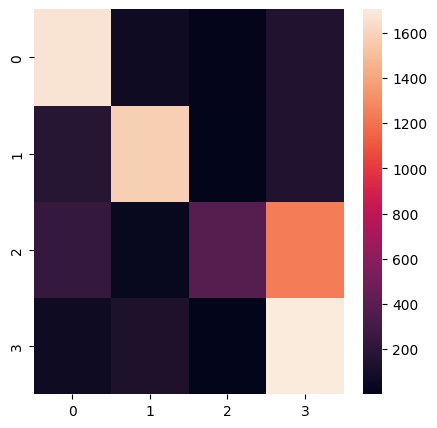

In [16]:
confusion_mat = confusion_matrix(y_true = y_test, y_pred = y_pred)
df_cm = pd.DataFrame(confusion_mat, index = list(range(4)),columns = list(range(4)))
plt.rcParams['figure.figsize'] = (5,5)
sns.heatmap(df_cm)

From the confusion matrix, it is evident that most examples of class '2' are getting classified as class '3' 

### Classification report

In [20]:
from sklearn.metrics import classification_report
print('classifiation report')
print(classification_report(y_test, y_pred))

classifiation report
              precision    recall  f1-score   support

           0       0.78      0.88      0.83      1900
           1       0.87      0.83      0.85      1900
           2       0.95      0.20      0.33      1900
           3       0.52      0.90      0.66      1900

    accuracy                           0.70      7600
   macro avg       0.78      0.70      0.67      7600
weighted avg       0.78      0.70      0.67      7600



From the report, we can infer that
1. model is performing very good for class '0' and class '1' as both classes have high precision and recall
2. Model is performing medicore for class '4' as precision value is low. It is classifying examples from other classes as class '3'
3. Model is perfoming bad for class '3' as recall value is very low. Model is not able to correctly identify 80% of total examples belonging to class '2' 